# Predicting Listing Gains in the Indian IPO Market Using TensorFlow
## Introduction
In this project, I'll assume the role of a data scientist for an investment firm that is interested in investing in the Initial Public Offerings (IPO) in the Indian market. I'll build a deep learning classification model to determine if there will be listing gains for the IPO. Listing gains are the percentage increase in the share price of a company from its IPO issue price on the day of listing.

The dataset I'll be using for this project contains information on past IPOs in the Indian market and comes from [moneycontrol](https://www.moneycontrol.com/ipo/listed-ipos/?classic=true).

I'll go through all the major steps of the modeling pipeline, starting with exploratory data analysis, then moving on to visualizing the important variables, then finally creating a deep learning classification model.



## Loading the Data
Start by loading and eploring the data.

In [1]:
# import the libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Read the data.

In [2]:
# read the data 
df = pd.read_csv('/Users/sumersener/Downloads/Datasets/Indian_IPO_Market_Data.csv')

Print and inspect the first and last rows of the dataset to get a feel for what the data looks like.

In [3]:
# inspect the first and last five cols
df.head()
df.tail()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
314,26/08/22,Syrma SGS,840.13,42.42,7.13,2.84,15.59,220,42.30
315,06/09/22,Dreamfolks Serv,562.10,27.48,14.18,24.19,23.25,326,41.92
316,15/09/22,TMB,792.00,0.51,1.77,3.44,1.39,525,-3.15
317,26/09/22,Harsha Engineer,755.00,113.82,40.36,12.44,47.19,330,47.24
318,17/10/22,Electronics Mar,500.00,58.81,15.39,8.27,24.23,59,43.14


Check for missing values in the data.

In [4]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB


As seen above there are no missing valuesi nthe data. Most of the columns have numeric type apart from `Date` and `IPOName`.

Next, examine the shape of the data.

In [5]:
# examine the shape of the data
df.shape

(319, 9)

Next, print the summary stats for the dataset.

In [6]:
# print summary stats for all variables in the dataset
df.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000


## Exploring the Data
The target variable we want to analyse is the `Listing_Gains_Percent` column. However, note that this column is continuous, making it difficult for us to build a deep learning classifier model for it. Hence, we will start by creating a new column `Listing_Gains_Profit`, which will have a 1 if `Listing_Gains_Percent` is non-negative and 0 otherwise.

In the next cell, create the `Listing_Gains_Profit` column as described above.

In [7]:
# create the col and drop the old one 
df['Listing_Gains_Profit'] = df['Listing_Gains_Percent'].apply(lambda x: 1 if x>=0 else 0)
df.drop('Listing_Gains_Percent', inplace = True , axis =1)
df.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,1
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,0
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,1
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,0
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,0


Explore what percentage of the IPOs are listed at a profit and what percentage are not.

In [8]:
# explore Listing_Gains_Profit column
df['Listing_Gains_Profit'].value_counts(normalize = True)

Listing_Gains_Profit
1    0.551724
0    0.448276
Name: proportion, dtype: float64

We see that than 55% of the IPOs are listed at a profit. We can also see that the cases and non-cases in our target columns `Listing_Gains_Profit` are comparable in number, therefore we don't need to worry about our model predicting cases or non-cases better than the other.

Next, print the summary stats againg to inspect the summary stats for the new `Listing_Gains_Profit` column we have created.

In [9]:
# print the summary stats again
df.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,0.551724
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,0.498099
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,0.000000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.000000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,1.000000


### Dropping Columns
I will get rid of the `Date` and `IPOName` columns because there is too much variance in the data. 319 out of 319 values are unique in the `IPOName` column! This is in parallel with my intuition because I don't expect the listing date of the IPO or the IPO name to have any effect on the profit the IPO brought in.

In [10]:
# drop the cols 
df.drop(columns=['Date ', 'IPOName'], axis = 1, inplace = True)
df.head()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
0,189.80,48.44,106.02,11.08,43.22,165,1
1,328.70,59.39,51.95,3.79,31.11,145,0
2,56.25,0.99,16.60,6.25,5.17,75,1
3,199.80,1.12,3.65,0.62,1.22,165,0
4,0.00,0.52,1.52,2.26,1.12,75,0


To analyse the columnns further consider the number of outliers in each column. Use the `skew()` method for this. I will remove the columns that are highly skewed, meaning if the skew of the columns is more than 1 or less than -1.

In [11]:
# compute the skewness of the columns
for col in list(df.columns):
    print(df[col].skew())

4.853401606434454
2.143704625584823
3.0784448213212667
3.7082740836630137
2.9119071381074786
1.6968814842159945
-0.2089966026782735


We can see that almost all of the columns are hightly skewed. We don't need to tackle the outliers at this point. First, we need to analyse the relationship between the predictor columns and the target column. Then, will we tackle the outliers in the columns that we decide to keep.

## Exploratory Data Analysis

### Distplot Analysis
I will plot displot of the potential feature columns stratified by our target variable to explore if they are good predictors for the target variable. Before I start, I will create a list of potential feature columns to work with.

Create a list of the potential feature columns we have in our dataset.

In [12]:
# create a list of cols 
potential_feature_cols = list(set(list(df.columns)) - set(['Listing_Gains_Profit']))
potential_feature_cols

['Subscription_RII',
 'Subscription_HNI',
 'Issue_Size',
 'Subscription_Total',
 'Subscription_QIB',
 'Issue_Price']

Having extracted the potential predictor columns for our analysis, plot a distplot of these columns stratified by the target column to see how well they predict the target column.

<Figure size 1200x1200 with 0 Axes>

[Text(0.5, 1.0, 'KDE Plots for Subscription_RII'),
 Text(0, 0.5, 'Subscription_RII'),
 []]

[Text(0.5, 1.0, 'KDE Plots for Subscription_HNI'),
 Text(0, 0.5, 'Subscription_HNI'),
 []]

[Text(0.5, 1.0, 'KDE Plots for Issue_Size'), Text(0, 0.5, 'Issue_Size'), []]

[Text(0.5, 1.0, 'KDE Plots for Subscription_Total'),
 Text(0, 0.5, 'Subscription_Total'),
 []]

[Text(0.5, 1.0, 'KDE Plots for Subscription_QIB'),
 Text(0, 0.5, 'Subscription_QIB'),
 []]

[Text(0.5, 1.0, 'KDE Plots for Issue_Price'), Text(0, 0.5, 'Issue_Price'), []]

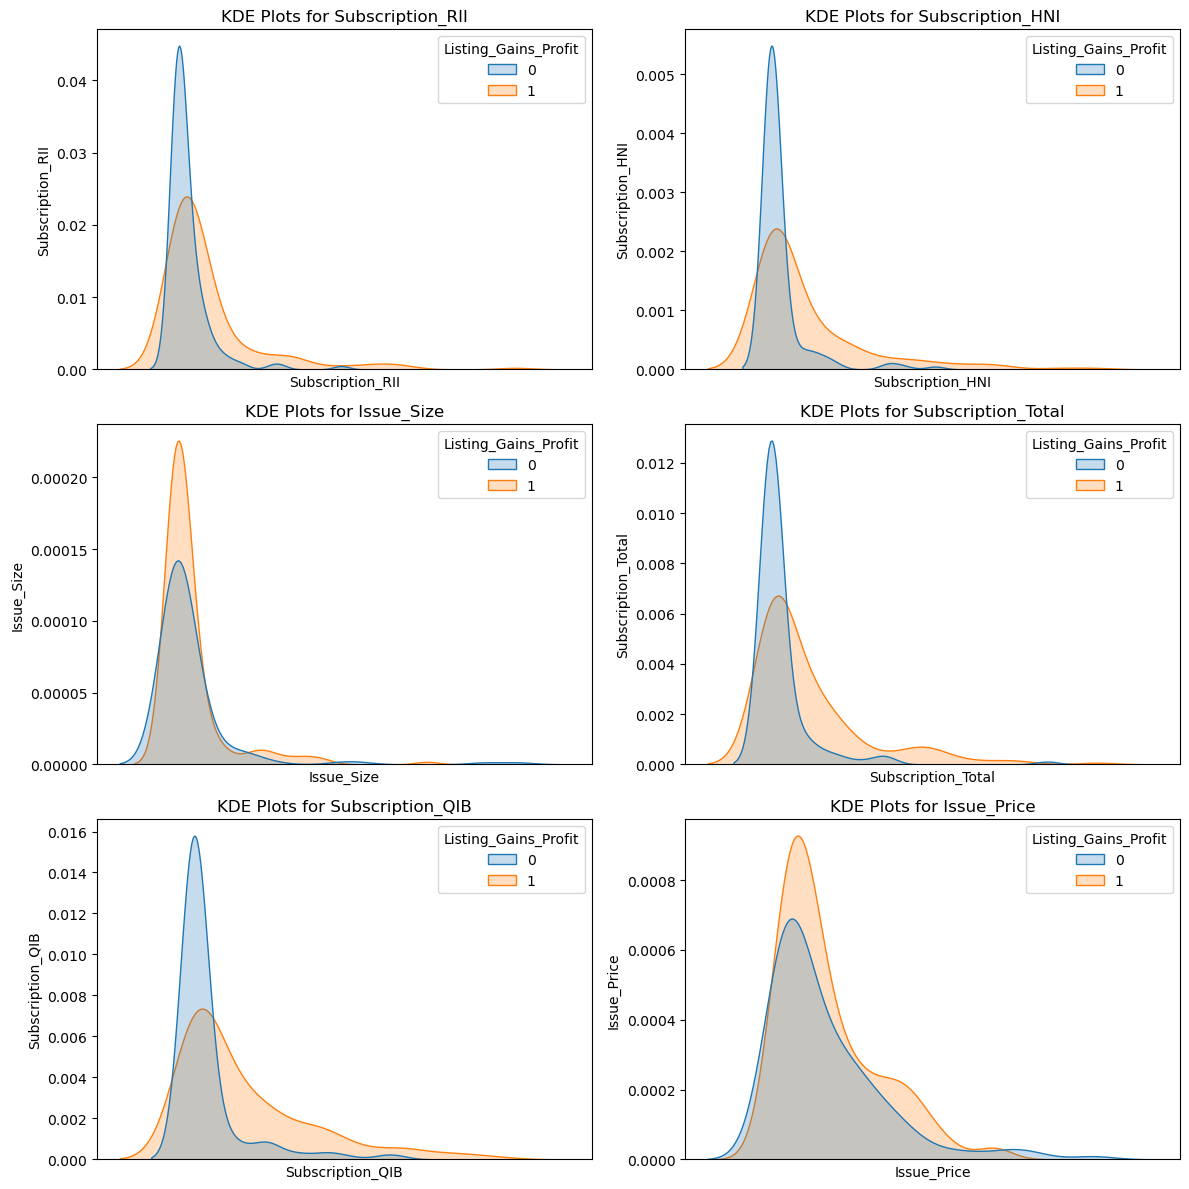

In [13]:
# plot the displots
plt.figure(figsize = (12,12))

for idx, col in enumerate(potential_feature_cols):
    ax = plt.subplot(3,2,idx+1)
    sns.kdeplot(data = df, 
                x=col, 
                hue="Listing_Gains_Profit",
                fill=True).set(title = f'KDE Plots for {col}',
                               ylabel = col,
                               xticks = [])
    
plt.tight_layout()    

We can clearly see from the kernel density plots above that the shape of the distribution for the cases and non-cases are almost identidal for the columns `Issue_Size` and `Issue_Price`. Hence, these two columns won't make good predictor columns for our target variable.

### Boxplot Analysis
Plot the boxplot of the potential feature columns stratified by the `Listing_Gains_Profit` column to see if they are correlated to the target column.

<Figure size 1200x1200 with 0 Axes>

[Text(0.5, 1.0, 'Boxplots for Subscription_RII'),
 Text(0, 0.5, 'Subscription_RII'),
 []]

[Text(0.5, 1.0, 'Boxplots for Subscription_HNI'),
 Text(0, 0.5, 'Subscription_HNI'),
 []]

[Text(0.5, 1.0, 'Boxplots for Issue_Size'), Text(0, 0.5, 'Issue_Size'), []]

[Text(0.5, 1.0, 'Boxplots for Subscription_Total'),
 Text(0, 0.5, 'Subscription_Total'),
 []]

[Text(0.5, 1.0, 'Boxplots for Subscription_QIB'),
 Text(0, 0.5, 'Subscription_QIB'),
 []]

[Text(0.5, 1.0, 'Boxplots for Issue_Price'), Text(0, 0.5, 'Issue_Price'), []]

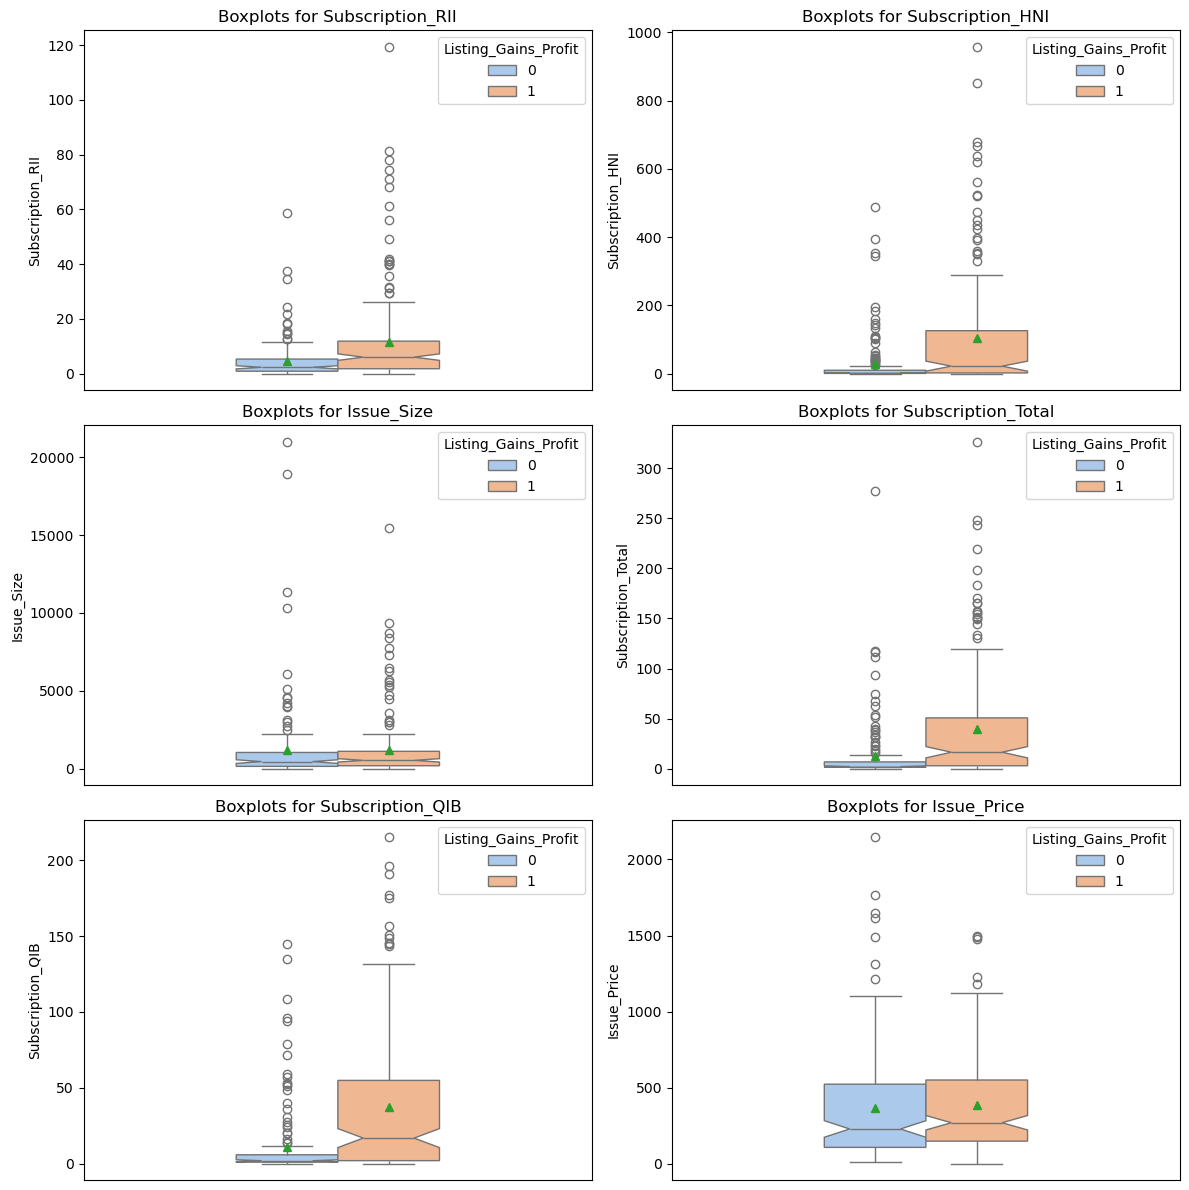

In [14]:
# plot the boxplots
plt.figure(figsize = (12,12))

for idx, col in enumerate(potential_feature_cols):
    ax = plt.subplot(3,2,idx+1)
    sns.boxplot(data = df,
                y = col,
                hue = 'Listing_Gains_Profit',
                palette = 'pastel',
                notch = True,
                width=0.4,
                showmeans = True).set(title = f'Boxplots for {col}',
                                     ylabel = col,
                                     xticks = [])
    
plt.tight_layout()    

Looking at the boxplots above, we can see straight away that the columns `Issue_Size` and `Issue_Price` do not do a good job of bringing out the differences between the cases and non-cases in the `Listing_Gains_Profit` column. Therefore, we might get rid of them. 
<br>
We see that the remaining four columns are doing a better job of stratifying the data based on the cases and non-cases in the target columns. 

### Heatmap Analysis
Plot a heatmap of the `potential_feature_cols` to decide which ones correlate better with the target column. Use the heatmap together with the boxplots above to decide which cols to keep and which ones to discard.

<Figure size 800x800 with 0 Axes>

<Axes: >

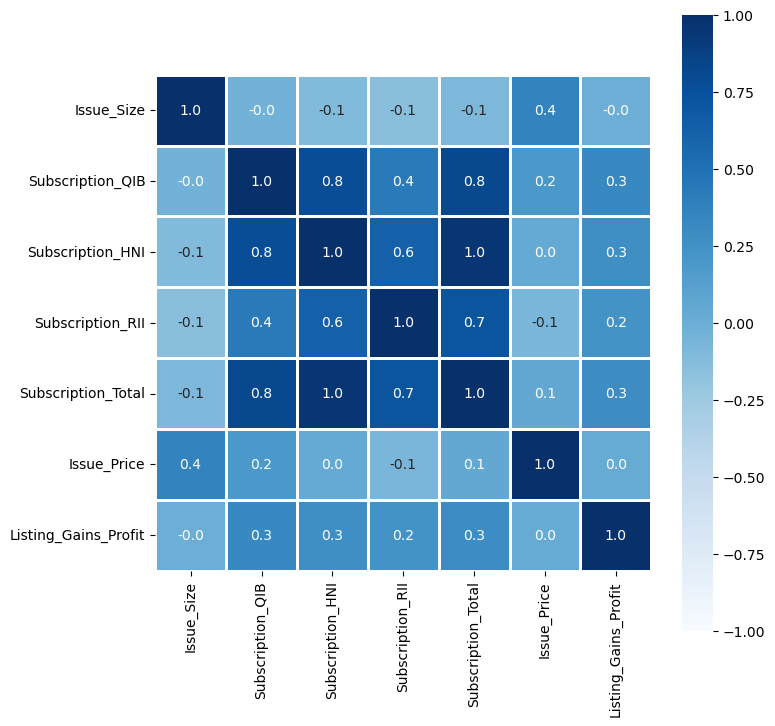

In [15]:
# plot a heatmap of the correlation matrix
plt.figure(figsize = (8,8))
sns.heatmap(df.corr()[df.corr().abs() >0], 
            cmap = 'Blues', 
            center = 0, 
            robust = True,
            vmin = -1, 
            vmax = 1, 
            annot = True, 
            fmt = '0.1f', 
            linewidth = 1, 
            square =True)

As expected, we can see that our target column doesn't correlate at all with the `Issue_Price` and `Issue_Size` columns. Hence, we can get rid of these two columns. 
<br>
I will also get rid of the `Subscription_HNI` column because there is perfect positive correlation between this column and `Suscription_Total` column in our dataset. Using both of them at the same time might introduce unnescessary complexity to our model and might cause it to overfit. get rid of `Subscription_QIB` column for the same reason as there is a really high correlation between it and `Subscription_Total` column in the data.

In [16]:
# define predictor cols 
predictors = ['Subscription_Total', 'Subscription_RII']

As a result of feature selection, I have the two columns above to train my model. Notice that there is still a very high correlation between these two columns: 0.6. This might cause our model to be overfit to the training data and this is something we should keep in mind when developing our model.

## Outlier Treatment
As was revealed by our boxplots above, our predictor columns have outliers in them. I will use the `clip()` method form the pandas library to tackle these outliers. Tackling the outliers is important because they may mislead our model. 

I will investigate the skewedness of the predictor columns to find out how serious the situation is with the outliers in my predictor columns.

In the next cell, print the skewedness score of the predictor columns.

In [17]:
# print the skewness of the predictor columns
df['Subscription_Total'].skew()
df['Subscription_RII'].skew()

2.9119071381074786

3.7082740836630137

Next, print the summary stats for the predictor columns.

In [18]:
# print the summary stats 
df[predictors].describe()

,Subscription_Total,Subscription_RII
count,319.000000,319.000000
mean,27.447147,8.561599
std,48.772203,14.508670
min,0.000000,0.000000
25%,1.645000,1.275000
50%,4.930000,3.420000
75%,33.395000,8.605000
max,326.490000,119.440000


Use the above table to calculate the interquartile range for both columns. Then calculate the cutoff points for both columns and use the `clip()` method to get rid of the outliers.

In [19]:
# clipping Subscription_Total column
q1 = df[predictors].describe().loc['25%', 'Subscription_Total']
q3 = df[predictors].describe().loc['75%', 'Subscription_Total']
iqr = q3 - q1
print(f'The interquartile range is : {iqr}.')
upper_bound = q3+ 1.5*iqr
lower_bound = q1 - 1.5*iqr
df['Subscription_Total'] = df['Subscription_Total'].clip(upper = upper_bound,
                                                         lower = lower_bound)
print(f"The skewedness of the Subscription_Total column is : {df['Subscription_Total'].skew()}.")

The interquartile range is : 31.749999999999996.
The skewedness of the Subscription_Total column is : 1.2938804195699385.


As seen above, we have greatly reduced the skewedness of the `Subscription_Total` column by clipping the outliers.

In [20]:
# clipping Subscription_RII column
q1 = df[predictors].describe().loc['25%', 'Subscription_RII']
q3 = df[predictors].describe().loc['75%', 'Subscription_RII']
iqr = q3 - q1
print(f'The interquartile range is : {iqr}.')
upper_bound = q3+ 1.5*iqr
lower_bound = q1 - 1.5*iqr
df['Subscription_RII'] = df['Subscription_RII'].clip(upper = upper_bound,
                                                         lower = lower_bound)
print(f"The skewedness of the Subscription_Total column is : {df['Subscription_RII'].skew()}.")

The interquartile range is : 7.33.
The skewedness of the Subscription_Total column is : 1.12917087322117.


Hence, we've reduced the skewness of both of the columns to below 1.3. This is still higher than 1, however, it is much better than what we had before. I will stop dealing with the outliers here because they may be representing genuine cases that are possible with respect to IPOs. For example, there might have been quite a few number of times when the IPO was subscribed by the RII (Retail Individual Investors) investor category. Hence, the skew in the `Subscription_RII` column.

##  Setting the Target and Predictor Variables
Givnen we have decided our predictor and target variables now, we can create arrays of target and predictor variables. Note that after creating the predictor variable array, we will need to normalise it so that all of the entries lie between 0 and 1. This is to ensure that our predictions aren't dominated by only one of the columns.

Start by assigning hte target and predictor columns to variables.

In [21]:
# create predictor and target arrays
X = df[predictors]
y = df['Listing_Gains_Profit']

Next, normalise the predictors so that all of the values lie in the range [0,1].

In [22]:
# normalise the predictor array
X = X/X.max()
X.describe()

,Subscription_Total,Subscription_RII
count,319.000000,319.000000
mean,0.252489,0.309232
std,0.335939,0.315147
min,0.000000,0.000000
25%,0.020304,0.065051
50%,0.060849,0.174490
75%,0.412182,0.439031
max,1.000000,1.000000


As seen above, normalization has been successful because all the values in both columns lie between 0 and 1. 

## Creating the Holdout Validation Approach
Use the holdout validation approach to split the dataset into two: training and test datasets. We will train our model on the training set and will test our models predictive potential using the test dataset. I will use the default value of 25% of the original data as my test dataset and 75% will be the training dataset. I will set `random_state` variable to `1` for reproducibility.

Perform holdout validation in the cell below as described.

In [23]:
# perform holdout validation 
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1)

Check that there is a balanced distribution of cases and non-cases in both the training and test sets. Having an imbalance in the distribution of the cases and non-cases in the datasets might cause our model to overfit or perform worse that it would've otherwise.

In [24]:
# check the percentages of the values in the target variable sets
y_train.value_counts(normalize = True)
y_test.value_counts(normalize = True)

Listing_Gains_Profit
1    0.548117
0    0.451883
Name: proportion, dtype: float64

Listing_Gains_Profit
1    0.5625
0    0.4375
Name: proportion, dtype: float64

Next, check the shape of our training and test sets.

In [25]:
# check the shape
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(239, 2)

(80, 2)

(239,)

(80,)

I have used holdout validation approach to divide my data into training and test datasets. I checked the percentage of the cases and non-cases found in the `y_train` and `y_test` datasets. The percentages found were extremely close to the 0.55-0.45 split in the original dataset.
<br>
The training data set has 239 observations and the test set has 80 observations. These are enough number of observations to train and test our data.

## Define the Deep Learning Classification Model
So far I have analysed the data and split it into training and test sets. In this section I will instantiate my deep learning model, add four hidden layers and choose my activation functions. An important thing to note is that the input layer will have two rows because we have two columns in our training dataset. Similarly, the output layer is going to have a single node because this is a classification model and we are only expecting one output: case or non-case, denoted by `1` and `0` respectively

The first dell learning model I deveop is going to have 4 fully connected layers not including the output layer. I will use varying numbers of neurons in these layers and will use `RelU` as the activation function for all of them.

In [26]:
# instantiate a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32,
                               input_shape = (X_train.shape[1], ),
                               activation = 'relu'))
model.add(tf.keras.layers.Dense(16,
                                activation='relu'))
model.add(tf.keras.layers.Dense(8,
                               activation='relu'))
model.add(tf.keras.layers.Dense(4,
                               activation='relu'))
model.add(tf.keras.layers.Dense(1))

### Compile and Train the model
I will use the Adam optimizer and will use the `mae(mean absolute error)` as my loss function and metric when compiling the model. I will fit the model to the training data and will train the model for 150 epochs.

I will use `BinaryCrossentropy` as my loss function because we are dealing with a classification problem and we have only two possible outcomes.

In [27]:
# compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.01)
model.compile(loss =tf.keras.losses.BinaryCrossentropy(),
              metrics = ['mae'],
              optimizer = optimizer)

Print the summary of the model and examine the structure of the deep learning model we've created.

In [28]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 801 (3.13 KB)
Trainable params: 801 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fit the model to the training data.

In [29]:
# fit the model on the training data
model.fit(X_train,
         y_train, 
         epochs=150,
         verbose=0)

### Model Evaluation
Evaluate the model on the train and test datasets and print the results to see how the model is performing. Check for overfitting issues, ideally we want to have accuracy scores that are comparable for both the train and test datasets.


In [30]:
# evaluate the model on the train and test datasets
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'The accuracy for the training set is : {train_acc}')
print(f'The accuracy for the test set is : {test_acc}')


3/3 [==============================] - 0s 1ms/step - loss: 0.6534 - mae: 0.4262
The accuracy for the training set is : 0.435505211353302
The accuracy for the test set is : 0.4262193739414215


Our model obtained comparable accuracy scores on the test and train sets. Hence, we do not need to worry about overfitting. However, our model is performing worse than a random guess right now so I will try to improve the accuracy score of the model in the next section.

## Improving the Model
With our previous model we obtained accuracy scores of roughly 0.55. In this section I will try to improve that via hyperparameter tuning. The main hyperparameters I will focus on are `epoch`, `learning_rate`, `metrics` and the activation function for the output layer.

Start by instantiating the model. This time use a different activation function `sigmoid` for the output layer.

In [31]:
# instantiate a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32,
                               input_shape = (X_train.shape[1], ),
                               activation = 'relu'))
model.add(tf.keras.layers.Dense(16,
                                activation='relu'))
model.add(tf.keras.layers.Dense(8,
                               activation='relu'))
model.add(tf.keras.layers.Dense(4,
                               activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

Next, use a lower `learning_rate` when compiling the model. Moreover, use the `accuracy` metric. 

In [32]:
# compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.001)
model.compile(loss =tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'],
              optimizer = optimizer)

Fit the model to the train data and train for 380 `epochs`.

In [33]:
# fit the model on the training data
model.fit(X_train,
         y_train, 
         epochs=380,
         verbose=0)

Evaluate the model on the train and test sets.

In [34]:
# evaluate the model on the train and test datasets
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 844us/step - loss: 0.5981 - accuracy: 0.7197


[0.5980699062347412, 0.7196652889251709]

3/3 [==============================] - 0s 1ms/step - loss: 0.5810 - accuracy: 0.7250


[0.580950140953064, 0.7250000238418579]

With the second model I have obtained an accuracy of 0.72 for the train data and 0.73 for the test data. The two are very close to each other, meaning that the model is not overfit.
<br>
Above I have played with the following parameters: `learning_rate`, `epochs`, `metrics`, and the activation function for the output layer. Part of the reason why I got higher accuracy with the second model is because `sigmoid` function is better for classification tasks, hence, it is also being used in logistic regression modelling.

## Conclusion
In this project, I have built Deep Learning Classification models using the deep learning framework, Keras, in TensorFlow. I used a real-world IPO dataset and built a classifier algorithm to predict whether an IPO will list at profit or not.

I started out by cleaning and analysing the data. I created my target column `Listing_Gains_Profit` by using feature engineering techniques. Then I performed exploratory data analysis to discover how the columns in the dataset are related to each other. I used feature selection and the visualisations from the exploratory data analysis to decide which columns to use as the predictors for my model. 

I used the holdout validation approach to divide the original data into train and test sets. Later on, I trained two different deep learning models using Sequential API. Although the first model wasn't very successful in predicting the target column `Listing_Gains_Profit`, the second model achieved an accuracy rating of 0.72 for the train data and 0.73 for the test data. 